# Tutorial 2:  Quantum Transport in 2D materials

## Introduction

**DPNEGF** is a Python package that integrates the Deep Learning Tight-Binding (**DeePTB**) approach with the Non-Equilibrium Green's Function (**NEGF**) method, 
establishing an efficient quantum transport simulation framework **DeePTB-NEGF** with first-principles accuracy. 

Based on the accurate electronic structure prediction in large-scale and complex systems, DPNEGF implements the
high-efficiency algorithm for high-throughput and large-scale quantum transport simulations in nanoelectronics.


### Learning Objectives

In this tutorial, you will learn:

1. how to extract model for specific systems from baseline model
2. what is principal layer and how to compute electrode self-energies with DeePTB model
3. how to compute the transmission spectrum of 2D materials with periodicity in the transverse direction

As demonstrations, we will explore graphene, hBN, and MoS<sub>2</sub>.


### Requirements

DeePTB and DPNEGF installed. Detailed installation instructions can be found in README.


## 1. Quantum Transport in Graphene
Two-dimensional (2D) materials have attracted significant attention in condensed matter physics and nanoelectronics owing to their unique properties. 

Graphene is the natural starting point for studying quantum transport in 2D materials. As the first experimentally realized 2D material, it combines a simple lattice structure with unique electronic features such as linear Dirac dispersion and high carrier mobility. 

In this section, we will use graphene to introduce the basic steps of quantum transport calculations, including the evaluation of electrode self-energies and transmission spectra. The same methodology will later be extended to hBN and MoS<sub>2</sub>.

In [3]:
import os
from pathlib import Path
workdir='../../examples/graphene'
wd = Path(workdir)
if not wd.is_dir():
    raise FileNotFoundError(f"Workdir '{wd}' not found. Please adjust 'workdir'.")
os.chdir(wd)
print("\t".join(sorted(os.listdir("."))))

band.json	band_plot_api	extra_baseline	negf.json	negf_output	negf_output_k100	negf_output_k20	stru_negf.xyz	struct.xyz	train


In [2]:
from dpnegf.utils.loggers import set_log_handles
import logging
from pathlib import Path


results_path = 'band_plot_api'
log_path = os.path.join(results_path, 'log')
log_level = logging.INFO
set_log_handles(log_level, Path(log_path) if log_path else None)

DPNEGF INFO    ================================================================================
DPNEGF INFO                                      Version Info                                  
DPNEGF INFO    --------------------------------------------------------------------------------
DPNEGF INFO    DPNEGF               : 0.1.1.dev148+0e0863a
DPNEGF INFO    DeePTB               : 2.2.1.dev17+024a5fe
DPNEGF INFO    ================================================================================



### 1.1 Extract system-specific model
Here we briefly outline the procedure for extracting a system-specific model from the baseline model. For more details, please refer to the  [DeePTB tutorial](https://www.bohrium.com/notebooks/15254953382).

First, decide on the elements and basis set for the target system. For graphene, we choose the 'spd*' for carbon, specified in `extra_baseline/c_spd.json`. The command `dptb esk c_spd.json -o grap_spd_model` generates the extracted model `sktb.json`.

To achieve higher accuracy, we further train the extracted model using `sktb.json` as the initialization.
The training input file `input_templete.json` can be automatically generated by: `dptb config -m grap_spd_model/sktb.json -tr -sk ./`.

After switching to the `train` directory  and copying the input file here as `input.json` ,the training process can be started with:
`dptb train input.json -i ../extra_baseline/grap_spd_model/sktb.json -o train_out`.

We recommend that users carefully examine the `input.json` file to understand the meaning of each parameter. 
For 2D materials, the onsite mode should be set to `strain`, which removes the degeneracy of onsite energies for orbitals with the same angular momentum. It is an essential adjustment for 2D systems. For example, the onsite energies for  $p_x,p_y,p_z$ in graphene should not be identical considering the geometry. Once training has converged, the resulting model can be loaded to plot and analyze the band structure.

**SUMMARY:**

In `./extra_baseline`: 
- `dptb esk c_spd.json -o grap_spd_model`
- `dptb config -m grap_spd_model/sktb.json -tr -sk ./`

In `./train`:
- `dptb train input.json -i ../extra_baseline/grap_spd_model/sktb.json -o train_out`

In [3]:
from dptb.nn.build import build_model

model =  "./train/train_out/checkpoint/nnsk.best.pth" # the model for demonstration

model = build_model(model)

DPNEGF INFO    The ['overlap_param'] are frozen!
DPNEGF INFO    The ['overlap_param'] are frozen!


In [4]:
# read the structure
from ase.io import read
structure =  "./train/data/POSCAR" 
atoms = read(structure)
atoms

Atoms(symbols='C2', pbc=True, cell=[[2.5039999485, 0.0, 0.0], [-1.2519999743, 2.1685275665, 0.0], [0.0, 0.0, 30.0]])

DPNEGF ERROR   TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
/opt/mamba/envs/dpnegf-dev/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return torch._nested_tensor_from_tensor_list(ts, dtype, None, device, None)
DPNEGF WARNING eig_solver is not set, using default 'torch'.
DPNEGF INFO    KPOINTS  klist: 300 kpoints
DPNEGF INFO    The eigenvalues are already in data. will use them.
DPNEGF INFO    Calculating Fermi energy in the case of spin-degeneracy.
DPNEGF WARNING Fermi level bisection did not converge under tolerance 1e-10 after 57 iterations.
DPNEGF INFO    q_cal: 7.9999999708937874, total_electrons: 8.0, diff q: 2.910621255125534e-08
DPNEGF INFO    Estimated E_fermi: -3.5829840898513794 based on the valence electrons setting nel_atom : {'C': 4} .
DPNEGF INFO   

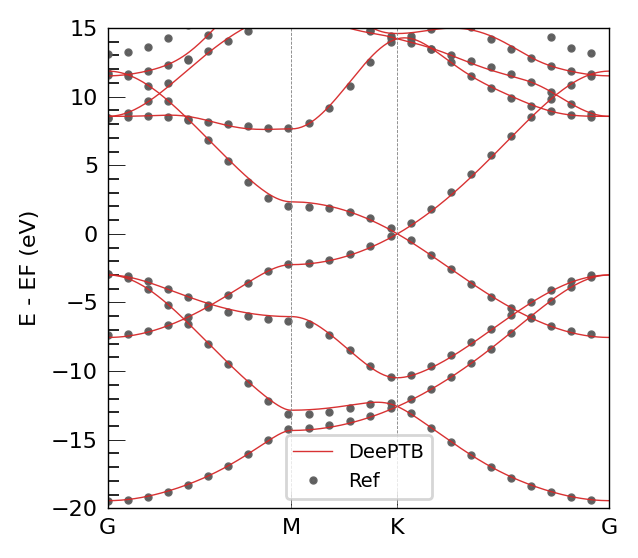

In [5]:
from dptb.postprocess.bandstructure.band import Band
import shutil

task_options = {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[
                [0, 0, 0, 110],
                [0.5, 0, 0, 62],
                [0.3333333, 0.3333333, 0, 127],
                [0, 0, 0, 1]
                ],
        "klabels":["G", "M", "K", "G"],
        "emin":-20,
        "emax": 15,
        "nel_atom":{"C": 4},
        "ref_band": "./train/data/kpath.0/eigenvalues.npy"

       }

if os.path.isdir(results_path):
    shutil.rmtree(results_path, ignore_errors=True) 

band = Band(model, results_path)
AtomicData_options = { "pbc": True}
band.get_bands(data = atoms, 
               kpath_kwargs = task_options,
               AtomicData_options = AtomicData_options)
band.band_plot(emin = task_options['emin'],
               emax = task_options['emax'],
               ref_band = task_options['ref_band'],)

### 1.2 Principal layers in leads

Now we can pay attention to quantum transport simulaitons.

In [6]:
try:
    from dpnegf.runner.NEGF import NEGF
except ImportError as e:
    raise ImportError("dpnegf not found. Please install firstly.") from e

import json
negf_input_file =  "negf.json" 
structure =  "stru_negf.xyz" 

with open(negf_input_file, "r") as f:
    negf_json = json.load(f)


DPNEGF INFO    Numba is available and JIT functions are compiled.


A critical component is `AtomicData_options`, which specifies the cutoff parameters for the model:
- `r_max`: the cutoff value for bond considering in TB model
- `er_max`: the cutoff value for environment correction, should set for nnsk+env correction model
- `oer_max`: the cutoff value for onsite correction in nnsk model, need to set in strain mode

In other words, `AtomicData_options` determines the **locality** of the model, i.e., how far atomic interactions are considered in the calculation.

The code would determine the `AtomicData_options` automatically with DeePTB v2.2. At the same time, it can be visiualized conviently
by `NEGF.update_atomicdata_options`.

In [7]:
AtomicData_options = NEGF.update_atomicdata_options(model)

DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "C-C": 4.99
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }


The largest cutoff value determines the **maximum interaction distance**, which is critical for defining the lead geometry in NEGF simulations.

In `DPNEGF`, a key requirement of the self-energy algorithm is to define two **principal layers (PLs)** for each lead. Each PL must be longer than the maximum interaction distance to ensure proper treatment of interactions. That is, the PLs only include **nearest-neighbor interactions**.

Additionally, the algorithm requires that:  

1. The PLs within the same lead be **identical, differing only by a translation** along the transport direction.  
2. In the input structure file, the atomic coordinates of the **left lead** should be ordered with the 1st PL first, followed by the 2nd PL. See `stru_negf.xyz` for reference.

The following figure illustrates the device/lead region and principal layers in the lead:

<div style="text-align: center;">
    <img src="./stru_negf_PL.png" alt="Geometry region in DPNEGF and Principal Layers in lead" style="width:75%;"/>
</div>

In this case, the length of PL should be larger than 6.3 $\AA$. However, too long PL is unnecessary for the computing cost. Considering both the translation requirement and nearest-neighbor interaction, we set the length of PL as 8.67 $\AA$.

Now we can strat the NEGF calculation!

### 1.3 NEGF calculation for graphene

For NEGF calculation on systems with leads having periodicity along the transverse direction, it's natural to calculate the $k$-resolved transmission $T(k,E)$ and sum up for the total transmission $T(E)$:
$$
T(E) = \sum_k w_k T(k,E)
$$
where $w_k$ is the weight for the specified $k$.

Firstly, we only consider the Gamma point calculation for graphene.

In [8]:
# Gamma point calculation
negf_json['task_options']["stru_options"]['kmesh'] = [1,1,1]
# Energy step and range for transmission calculation
print(f"Energy range: {negf_json['task_options']['emin']} to {negf_json['task_options']['emax']} eV, step: {negf_json['task_options']['espacing']} eV")

Energy range: -10 to 10 eV, step: 0.05 eV


Here `kmesh` specify  the $k$-point mesh for transmission calculaiton.
`k_mesh_lead_Ef` is the $k$-point mesh for lead Fermi level determination.
For leads with long PLs, a sparse `kmesh_lead_Ef` is enough.

In [9]:
# Structural information for device and electrodes
negf_json['task_options']["stru_options"]

{'gamma_center': False,
 'time_reversal_symmetry': True,
 'nel_atom': {'C': 4},
 'kmesh': [1, 1, 1],
 'pbc': [False, True, False],
 'device': {'id': '32-64', 'sort': True},
 'lead_L': {'id': '0-32',
  'voltage': 0.0,
  'kmesh_lead_Ef': [1, 50, 20],
  'useBloch': False},
 'lead_R': {'id': '64-96',
  'voltage': 0.0,
  'kmesh_lead_Ef': [1, 50, 20],
  'useBloch': False}}

Now we can run the NEGF calculation ( ~2 mins in a 8-core CPU ):

DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False
DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 1
DPNEGF INFO    k-points: [[-0. -0. -0.]]
DPNEGF INFO    k-points weights: [1.]
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "C-C": 4.99
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732051e-10 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732061e-10 (threshold: 1.000000e-05)
DPNEGF INFO    The coupling width of lead_L is 72.
DPNEGF WARNING WARNING, the lead's hamiltonian attained from diffferent methods have slight differences   RMSE = 0.0000006.
DP

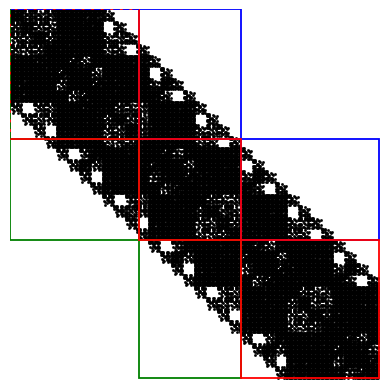

In [10]:
output = "./negf_output"  
if os.path.isdir(output):
    shutil.rmtree(output, ignore_errors=True)
os.makedirs(output, exist_ok=True)

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output,
    use_saved_se=False, # whether to use the saved self-energy  
    se_info_display=False,
    **negf_json['task_options']
)
   
negf.compute()

Read the results through the dict `negf_out`:

In [11]:
import torch
import matplotlib.pyplot as plt
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

In [12]:
negf_out.keys()

dict_keys(['k', 'wk', 'uni_grid', 'DOS', 'T_k', 'LDOS', 'T_avg'])

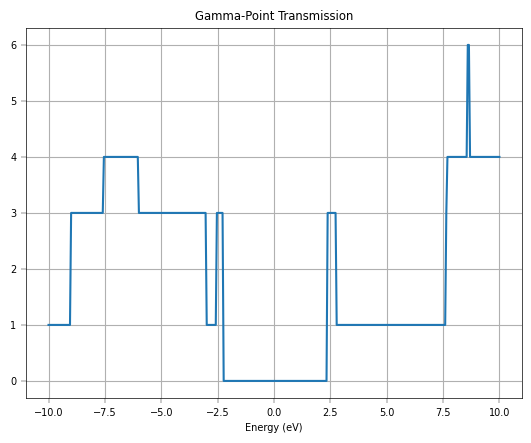

In [13]:
plt.plot(negf_out['uni_grid'], negf_out['T_avg'])
plt.xlabel('Energy (eV)')
plt.title('Gamma-Point Transmission')
plt.grid()
plt.show()

Furthermore, we increase the $k$-point mesh for transmission.

In [14]:
# Increase k-point sampling for better accuracy
negf_json['task_options']["stru_options"]['kmesh'] = [1,20,1]

For $k$-point mesh [1,20,1], the computation from scratch takes ~23 mins in a 8-core CPU.
However, if directly loading the saved self-energies, it takes ~6 mins. 

We have prepared the self-energies in `negf_out_k20/self_energy` and you can just run the cell with `use_saved_se=True`.

DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False
DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 10
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "C-C": 4.99
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732051e-10 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 1.732061e-10 (threshold: 1.000000e-05)
DPNEGF INFO    The coupling width of lead_L is 72.
DPNEGF WARNING WARNING, the lead's hamiltonian attained from diffferent methods have slight differences   RMSE = 0.0000006.
DPNEGF INFO    The coupling width of lead_R is 72.
DPNEGF WARNING WARNING, the l

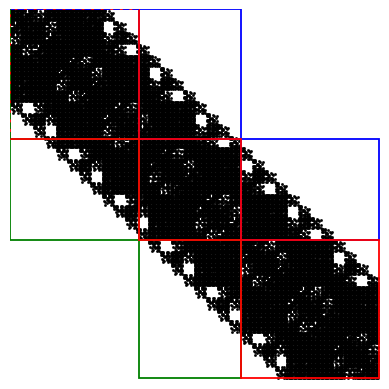

In [15]:
output = "./negf_output_k20"

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output, 
    use_saved_se=True,   # use the saved self-energy to speed up calculation
    **negf_json['task_options']
)
   
negf.compute()

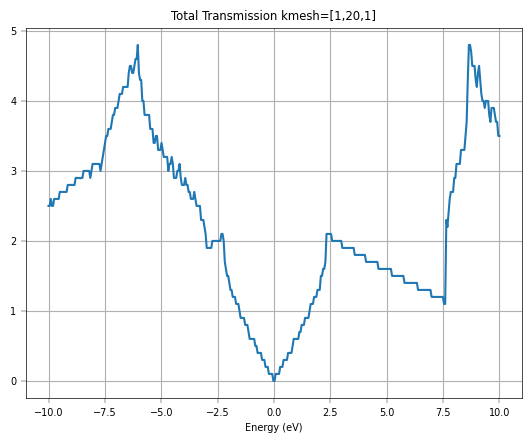

In [ ]:
output = "./negf_output_k20"
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

plt.plot(negf_out['uni_grid'], negf_out['T_avg'])
plt.xlabel('Energy (eV)')
plt.title('Total Transmission kmesh=[1,20,1]')
plt.xlim(-10,10)
plt.grid()
plt.show()

If we further increase the $k$-point mesh density, we can get a smoother transmission curve for graphene. Considering the time, we directly plot the total transmission corresponding to $k$-point mesh [1,100,1], and compare it with DFT-NEGF (TranSIESTA + TBtrans). 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
output = 'negf_output_k100'
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)
Erange_dpnegf = np.linspace(-15,15,int((15-(-15))/0.05))

In [6]:
tbt_trans_E = np.load(os.path.join(output, 'trans_tbt_E.npy'))
tbt_trans = np.load(os.path.join(output, 'trans_tbt_Tavg.npy'))
Ef_TS = -24.878582000732422

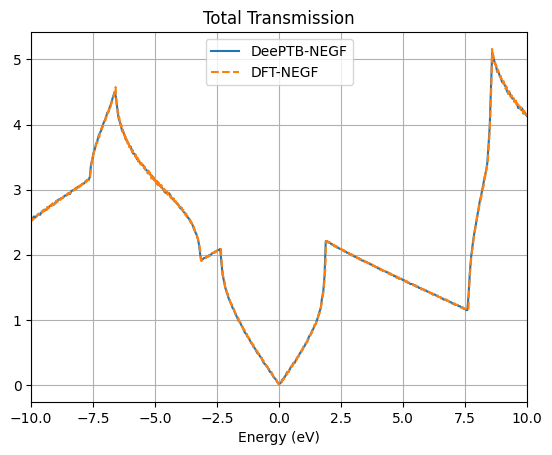

In [11]:
plt.plot(Erange_dpnegf, negf_out['T_avg'], label='DeePTB-NEGF')
plt.plot(tbt_trans_E - Ef_TS, tbt_trans,'--', label=r'DFT-NEGF')
plt.xlabel('Energy (eV)')
plt.title('Total Transmission')
plt.grid()
plt.legend(loc='upper center')
plt.xlim(-10,10)
plt.show()

## 2. Quantum Transport in hBN

Here we extend DPNEGF's application to **hBN** illustrating its capability to various materials.

For simpilicy, we have prepared a model in `example/hBN/train/`. Users can just run the same commands above to repeat the procedures.

In [1]:
import os
from pathlib import Path
from dptb.nn.build import build_model
from ase.io import read
from dpnegf.utils.loggers import set_log_handles
import logging
from pathlib import Path


workdir='../../examples/hBN'
wd = Path(workdir)
if not wd.is_dir():
    raise FileNotFoundError(f"Workdir '{wd}' not found. Please adjust 'workdir'.")
os.chdir(wd)
print("\t".join(sorted(os.listdir("."))))

results_path = 'band_plot_api'
log_path = os.path.join(results_path, 'log')
log_level = logging.INFO
set_log_handles(log_level, Path(log_path) if log_path else None)


model =  "./train/train_out/checkpoint/nnsk.best.pth" # the model for demonstration
model = build_model(model)

# read the structure
structure =  "./train/data/POSCAR" 
atoms = read(structure)
print(atoms)


DPNEGF INFO    ================================================================================
DPNEGF INFO                                      Version Info                                  
DPNEGF INFO    --------------------------------------------------------------------------------
DPNEGF INFO    DPNEGF               : 0.1.1.dev148+0e0863a
DPNEGF INFO    DeePTB               : 2.2.1.dev17+024a5fe
DPNEGF INFO    ================================================================================

DPNEGF INFO    The ['overlap_param'] are frozen!
DPNEGF INFO    The ['overlap_param'] are frozen!


band.json	band_plot_api	extra_baseline	negf.json	negf_output	negf_output_k20	negf_output_k50	stru_negf.xyz	train
Atoms(symbols='NB', pbc=True, cell=[[2.5039999485, 0.0, 0.0], [-1.2519999743, 2.1685275665, 0.0], [0.0, 0.0, 30.0]])


The band predicted by the model is shown:

DPNEGF ERROR   TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
/opt/mamba/envs/dpnegf-dev/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return torch._nested_tensor_from_tensor_list(ts, dtype, None, device, None)
DPNEGF WARNING eig_solver is not set, using default 'torch'.
DPNEGF INFO    KPOINTS  klist: 300 kpoints
DPNEGF INFO    The eigenvalues are already in data. will use them.
DPNEGF INFO    Calculating Fermi energy in the case of spin-degeneracy.
DPNEGF INFO    Fermi energy converged after 3 iterations.
DPNEGF INFO    q_cal: 7.999999999999999, total_electrons: 8.0, diff q: 8.881784197001252e-16
DPNEGF INFO    Estimated E_fermi: -2.8933583906146634 based on the valence electrons setting nel_atom : {'B': 3, 'N': 5} .
DPNEGF INFO    No Fermi energy provided, using

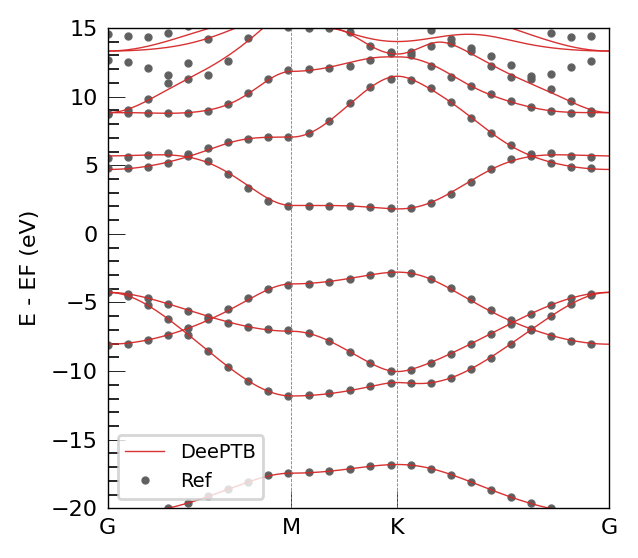

In [2]:
from dptb.postprocess.bandstructure.band import Band


task_options = {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[
                [0, 0, 0, 110],
                [0.5, 0, 0, 62],
                [0.3333333, 0.3333333, 0, 127],
                [0, 0, 0, 1]
                ],
        "klabels":["G", "M", "K", "G"],
        "emin":-20,
        "emax": 15,
        "nel_atom":{"B": 3,
                    "N": 5},
        "ref_band": "./train/data/kpath.0/eigenvalues.npy"

       }



band = Band(model, results_path)
AtomicData_options = { "pbc": True}
band.get_bands(data = atoms, 
               kpath_kwargs = task_options,
               AtomicData_options = AtomicData_options)
band.band_plot(emin = task_options['emin'],
               emax = task_options['emax'],
               ref_band = task_options['ref_band'],)

The NEGF calculation on hBN can be done:

In [3]:
try:
    from dpnegf.runner.NEGF import NEGF
except ImportError as e:
    raise ImportError("dpnegf not found. Please install firstly.") from e

import json
negf_input_file =  "negf.json" 
structure =  "stru_negf.xyz" 

with open(negf_input_file, "r") as f:
    negf_json = json.load(f)


DPNEGF INFO    Numba is available and JIT functions are compiled.


In [4]:
AtomicData_options = NEGF.update_atomicdata_options(model)

DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "B-B": 4.82,
                       "B-N": 4.640000000000001,
                       "N-B": 4.640000000000001,
                       "N-N": 4.45
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }


DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False


DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 1
DPNEGF INFO    k-points: [[-0. -0. -0.]]
DPNEGF INFO    k-points weights: [1.]
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "B-B": 4.82,
                       "B-N": 4.640000000000001,
                       "N-B": 4.640000000000001,
                       "N-N": 4.45
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 3.803219e-09 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 2.120221e-09 (threshold: 1.000000e-05)
DPNEGF INFO    The coupling width of lead_L is 54.
DPNEGF WARNING WARNING, the lead's hamiltonian attained from diffferent 

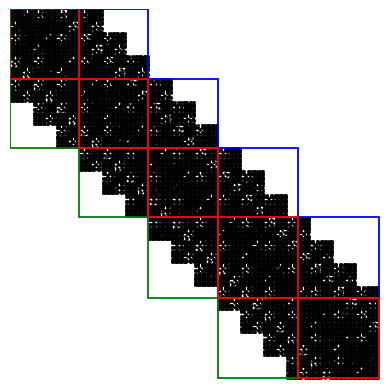

In [6]:
import shutil
output = "./negf_output"  
if os.path.isdir(output):
    shutil.rmtree(output, ignore_errors=True)
os.makedirs(output, exist_ok=True)

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output,
    use_saved_se=False, # whether to use the saved self-energy  
    se_info_display=False,
    **negf_json['task_options']
)
   
negf.compute()

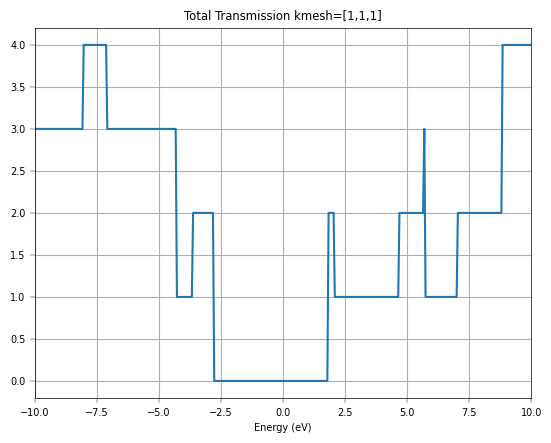

In [9]:
import torch
import matplotlib.pyplot as plt

output = "./negf_output"
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

plt.plot(negf_out['uni_grid'], negf_out['T_avg'])
plt.xlabel('Energy (eV)')
plt.title('Total Transmission kmesh=[1,1,1]')
plt.xlim(-10,10)
plt.grid()
plt.show()

In [5]:
# Increase k-point sampling for better accuracy
negf_json['task_options']["stru_options"]['kmesh'] = [1,20,1]

As well, it takes 23 mins in a 8-core CPU.

DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False
DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 10
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "B-B": 4.82,
                       "B-N": 4.640000000000001,
                       "N-B": 4.640000000000001,
                       "N-N": 4.45
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 3.803219e-09 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 2.120221e-09 (threshold: 1.000000e-05)
DPNEGF INFO    The coupling width of lead_L is 54.
DPNEGF WARNING WARNING, the lead's hamiltonian attained from diffferen

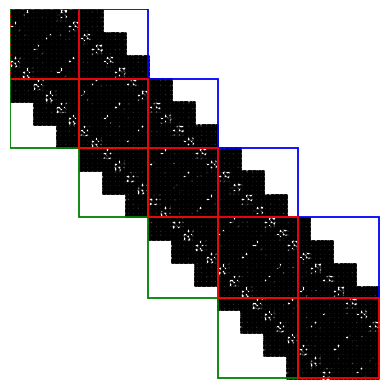

In [11]:
output = "./negf_output_k20"  
os.makedirs(output, exist_ok=True)

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output,
    use_saved_se=False, # whether to use the saved self-energy  
    se_info_display=False,
    **negf_json['task_options']
)
   
negf.compute()

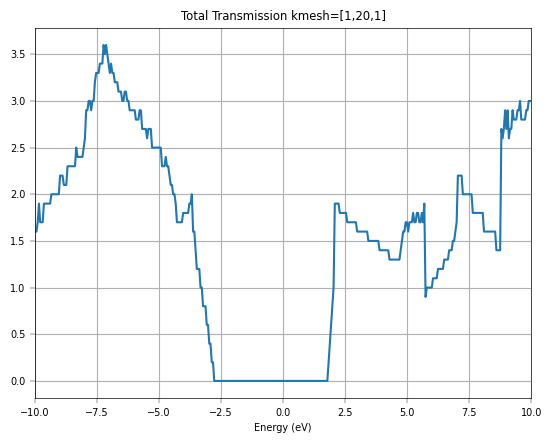

In [12]:
import torch
import matplotlib.pyplot as plt

output = "./negf_output_k20"
results_path = os.path.join(output, 'negf.out.pth')
if os.path.exists(results_path) is False:
    raise FileNotFoundError(f"Results file {results_path} not found. Please check if the NEGF calculation was successful.")
negf_out = torch.load(results_path,weights_only=False)

plt.plot(negf_out['uni_grid'], negf_out['T_avg'])
plt.xlabel('Energy (eV)')
plt.title('Total Transmission kmesh=[1,20,1]')
plt.xlim(-10,10)
plt.grid()
plt.show()

In [13]:
negf_out = torch.load('/personal/zjj/transiesta_cal/hBN_formal/dptb_negf_zigzag_trans/negf/results/negf.k0.out.pth')
negf_out.keys()

/tmp/ipykernel_1488/948984070.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  negf_out = torch.load('/personal/zjj/transiesta_cal/hBN_formal/dptb_negf_zigzag_trans/negf/

dict_keys(['k', 'DOS', 'TC', 'LDOS', 'BIAS_POTENTIAL_NSCF', 'CURRENT_NSCF', 'DM_eq', 'DM_neq', 'LOCAL_CURRENT'])

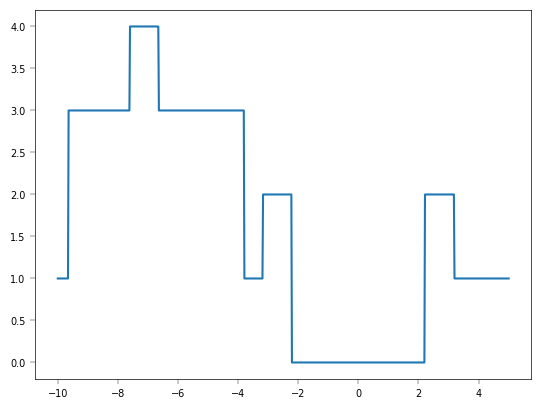

In [18]:
import numpy as np
Erange = np.linspace(-10,5,int((5-(-10))/0.02))
plt.plot(Erange, negf_out['TC'])
plt.show()

In [20]:
# Increase k-point sampling for better accuracy
negf_json['task_options']["stru_options"]['kmesh'] = [1,50,1]

DPNEGF INFO    ------ k-point for NEGF -----
DPNEGF INFO    Gamma Center: False
DPNEGF INFO    Time Reversal: True
DPNEGF INFO    k-points Num: 10
DPNEGF INFO    --------------------------------
DPNEGF INFO    The AtomicData_options is:
               {
                   "r_max": {
                       "B-B": 4.82,
                       "B-N": 4.640000000000001,
                       "N-B": 4.640000000000001,
                       "N-N": 4.45
                   },
                   "er_max": null,
                   "oer_max": 6.3
               }
DPNEGF INFO    The structure is sorted lexicographically in this version!
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 3.803219e-09 (threshold: 1.000000e-05)
DPNEGF INFO    Lead principal layers translational equivalence error (on average): 2.120221e-09 (threshold: 1.000000e-05)
DPNEGF INFO    The coupling width of lead_L is 54.
DPNEGF WARNING WARNING, the lead's hamiltonian attained from diffferen

KeyboardInterrupt: 

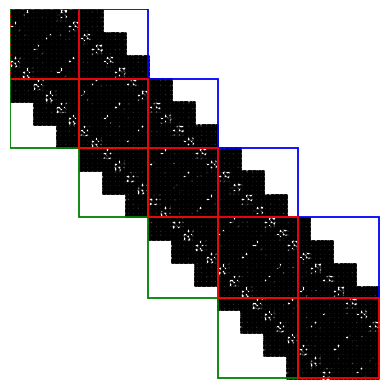

In [6]:
output = "./negf_output_k50"  
os.makedirs(output, exist_ok=True)

negf = NEGF(
    model=model,
    structure=structure,
    results_path=output,
    use_saved_se=False, # whether to use the saved self-energy  
    se_info_display=False,
    **negf_json['task_options']
)
   
negf.compute()